In [209]:
# import relevant libraries
import osmnx as ox
import folium as fl
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

### 1. Extract Generators

In [210]:
# load & combine generator data from osmnx (i.e. Overpass) for SN & BB
generators_sachsen = ox.features.features_from_place("Sachsen, Germany", tags = {'power':['plant','generator']})
generators_brandenburg = ox.features.features_from_place("Brandenburg, Germany", tags = {'power':['plant','generator']})

/Users/nf/.local/share/mamba/envs/casestudy/lib/python3.13/site-packages/osmnx/_overpass.py:271: UserWarning: This area is 15 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


In [211]:
generators = gpd.GeoDataFrame(pd.concat([generators_sachsen, generators_brandenburg], ignore_index=True))
# print(generators_sachsen.columns.to_frame())
vars_to_keep = ['geometry',
                'generator:source',
                'generator:output:electricity',
                'generator:method', 
                'generator:type']


generators = generators[vars_to_keep]
generators.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 40600 entries, 0 to 40599
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   geometry                      40600 non-null  geometry
 1   generator:source              39655 non-null  object  
 2   generator:output:electricity  37393 non-null  object  
 3   generator:method              38390 non-null  object  
 4   generator:type                36077 non-null  object  
dtypes: geometry(1), object(4)
memory usage: 1.5+ MB


### 2. Extract Substations

In [212]:
# load & combine power substation data from osmnx
substations_sachsen = ox.features.features_from_place("Sachsen, Germany", tags = {'power':'substation'})
substations_brandenburg = ox.features.features_from_place("Brandenburg, Germany", tags = {'power':'substation'})

/Users/nf/.local/share/mamba/envs/casestudy/lib/python3.13/site-packages/osmnx/_overpass.py:271: UserWarning: This area is 15 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


In [213]:
substations = gpd.GeoDataFrame(pd.concat([substations_sachsen, substations_brandenburg], ignore_index=True))
# print(substations.columns.to_frame())
vars_to_keep = ['geometry',
                'voltage',
                'frequency'] # just out of curiosity


substations = substations[vars_to_keep]
substations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8370 entries, 0 to 8369
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   geometry   8370 non-null   geometry
 1   voltage    1077 non-null   object  
 2   frequency  741 non-null    object  
dtypes: geometry(1), object(2)
memory usage: 196.3+ KB


In [214]:
# get overview of voltage of values in voltage
print(substations['voltage'].value_counts())

voltage
110000           546
20000;400        152
20000            127
380000            30
10000;400         29
110000;15000      25
10000             19
15000             18
110000;20000      18
21000;400         17
30000;750         16
30000             12
20000;110000       9
220000             8
400                7
30000;15000        4
110000;30000       4
400;20000          4
220000;110000      3
63000              3
600                3
110000;31500       2
low                2
medium;low         2
110000;10000       2
380000;110000      2
20000;15000        2
21000              1
660_v_dc           1
30000;10000        1
110000;400         1
0                  1
medium;400         1
1028               1
1000               1
110000;33000       1
20                 1
11000              1
Name: count, dtype: int64


In [215]:
# drop rows where voltage is NaN
substations = substations[substations['voltage'].notna()]

# filter substations for voltage >= 110000V
substations_transmission = substations[substations['voltage'].apply(lambda x: any(int(v) >= 110000 for v in str(x).split(';') if v.isdigit()))]

In [216]:
substations_transmission.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 651 entries, 1318 to 8360
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   geometry   651 non-null    geometry
 1   voltage    651 non-null    object  
 2   frequency  422 non-null    object  
dtypes: geometry(1), object(2)
memory usage: 20.3+ KB


### 3. Assign Bundesland Information

In [217]:
# load Länder polygons via osmnx nominatim (way faster than querying via osmnx / Overpass)

states = ["Brandenburg","Sachsen"]

gdf = ox.geocode_to_gdf([f"{s}, Germany" for s in states])
laender = gdf[["name","geometry"]]


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

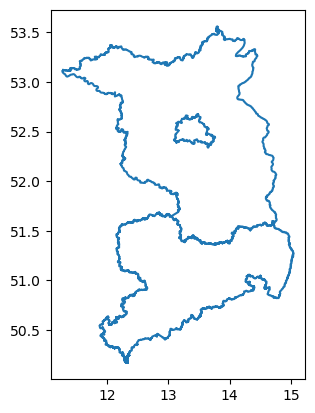

In [218]:
# quick check of länder geometries
laender.boundary.plot()
laender.crs

In [219]:
# make a 'within' spatial join to get Bundesland for each substation
substations_transmission.crs
laender = laender.to_crs(substations_transmission.crs)

substations_transmission = gpd.sjoin(substations_transmission, laender, how="left", predicate='within')
substations_transmission.drop(columns=['index_right'], inplace=True)
substations_transmission.rename(columns={'name':'Bundesland'}, inplace=True)

In [220]:
substations_transmission.head()

,geometry,voltage,frequency,Bundesland
1318,"POLYGON ((12.36006 51.29549, 12.36041 51.2955,...",110000,NaN,Saxony
1322,"POLYGON ((12.37123 51.17663, 12.37129 51.17663...",110000,NaN,Saxony
1323,"POLYGON ((13.61047 51.09218, 13.60903 51.09184...",110000,50,Saxony
1324,"POLYGON ((12.26329 51.24467, 12.26367 51.24455...",110000,50,Saxony
1325,"POLYGON ((12.23262 51.29287, 12.23231 51.29284...",110000,50,Saxony


Bundesland
Brandenburg    405
Saxony         246
Name: count, dtype: int64


<Axes: >

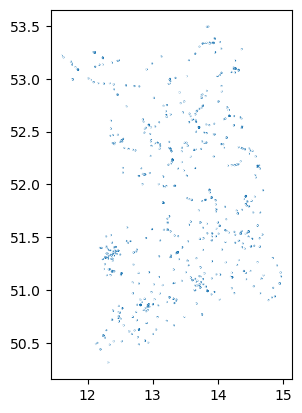

In [221]:
print(substations_transmission.value_counts('Bundesland'))
substations_transmission.boundary.plot()

### 4. Associate Generators to Substations

In [222]:
substations_transmission.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 651 entries, 1318 to 8360
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geometry    651 non-null    geometry
 1   voltage     651 non-null    object  
 2   frequency   422 non-null    object  
 3   Bundesland  651 non-null    object  
dtypes: geometry(1), object(3)
memory usage: 25.4+ KB


In [223]:
substations_transmission.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [224]:
# set substations and generators to same crs, fitting Germany
substations_transmission = substations_transmission.to_crs("EPSG:25833")
generators = generators.to_crs(substations_transmission.crs)

# get the nearest substation for each generator
generators_with_substations = gpd.sjoin_nearest(generators, substations_transmission,
                            how="left", distance_col="dist")



In [225]:
generators_with_substations.head()

,geometry,generator:source,generator:output:electricity,generator:method,generator:type,index_right,voltage,frequency,Bundesland,dist
0,POINT (396443.993 5639269.346),wind,1.8 MW,wind_turbine,horizontal_axis,1495,110000,NaN,Saxony,10459.341908
1,POINT (396010.786 5639776.856),wind,600 kW,wind_turbine,horizontal_axis,1495,110000,NaN,Saxony,11023.764769
2,POINT (396066.235 5640136.06),wind,600 kW,wind_turbine,horizontal_axis,1495,110000,NaN,Saxony,11088.844679
3,POINT (400094.281 5657513.302),wind,1000 kW,wind_turbine,horizontal_axis,1323,110000,50,Saxony,4254.620483
4,POINT (361743.592 5661363.86),hydro,yes,run-of-the-river,NaN,1866,110000,50,Saxony,3643.135617


In [226]:
# for generators and substations, show the value count of geometry types
print(generators['geometry'].geom_type.value_counts())
print(substations['geometry'].geom_type.value_counts())

Polygon         31033
Point            9498
MultiPolygon       58
LineString         11
Name: count, dtype: int64
Polygon    1012
Point        65
Name: count, dtype: int64


In [227]:
# subset every 100th generator to have a more performant map
ps_plot = generators_with_substations[::100]

sub_plot = substations_transmission.copy()

In [228]:
sub_plot.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 651 entries, 1318 to 8360
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geometry    651 non-null    geometry
 1   voltage     651 non-null    object  
 2   frequency   422 non-null    object  
 3   Bundesland  651 non-null    object  
dtypes: geometry(1), object(3)
memory usage: 25.4+ KB


In [229]:

if ps_plot.crs is None or ps_plot.crs.to_epsg() != 4326:
    ps_plot = ps_plot.to_crs(epsg=4326)

if sub_plot.crs is None or sub_plot.crs.to_epsg() != 4326:
    sub_plot = sub_plot.to_crs(epsg=4326)

# representative point for all geometries
rep_points = ps_plot.geometry.apply(lambda g: g if g.geom_type == 'Point' else g.centroid)

# center map on data
center_lat = rep_points.y.mean()
center_lon = rep_points.x.mean()
m = fl.Map(location=[center_lat, center_lon], zoom_start=7)

# add power stations with popups
for idx, row in ps_plot.iterrows():
    geom = row.geometry
    if geom.is_empty:
        continue
    if geom.geom_type == 'Point':
        lat, lon = geom.y, geom.x
    else:
        c = geom.centroid
        lat, lon = c.y, c.x
    popup = (f"Generator: {row.get('generator:method', 'n/a')}, \n"
             f"Source: {row.get('generator:source','n/a')}, \n"
             f"Output: {row.get('generator:output:electricity','n/a')}, \n"
             f"Nearest Substation: {row.get('index_right','n/a')}")
    fl.Marker(location=[lat, lon], popup=popup).add_to(m)

# add substations with popups
for idx, row in sub_plot.iterrows():
    geom = row.geometry
    if geom.is_empty:
        continue
    if geom.geom_type == 'Point':
        lat, lon = geom.y, geom.x
    else:
        c = geom.centroid
        lat, lon = c.y, c.x
    popup = (f"Substation Voltage: {row.get('voltage', 'n/a')}, \n"
             f"Frequency: {row.get('frequency','n/a')}, \n"
             f"Bundesland: {row.get('Bundesland','n/a')}, \n"
             f"Index: {idx}")
    fl.Marker(location=[lat, lon], popup=popup, icon=fl.Icon(color='green', icon='flash')).add_to(m)

m.save("output/power_stations_map.html")


## 5. Aggregate and Summarize

### Number of nearby generators for each substations

In [230]:
BUFFER = 5_000

# set substations and generators to same crs, fitting Germany
sub = substations_transmission.to_crs("EPSG:25833")
gen = generators.to_crs(substations_transmission.crs)


pairs = gpd.sjoin(sub.assign(geometry=sub.geometry.buffer(BUFFER)),
                  gen[["geometry"]], predicate="intersects", how="left")

counts = pairs.groupby(level=0).size().reindex(sub.index, fill_value=0).rename(f"substations_within_{BUFFER/1000}_km")

substations_metrics = sub.join([counts])

In [231]:
substations_metrics[f"substations_within_{BUFFER/1000}_km"].describe()

count     651.000000
mean      191.316436
std       572.067679
min         1.000000
25%        17.000000
50%        42.000000
75%       108.500000
max      5741.000000
Name: substations_within_5.0_km, dtype: float64

### Breakdown of generators by type

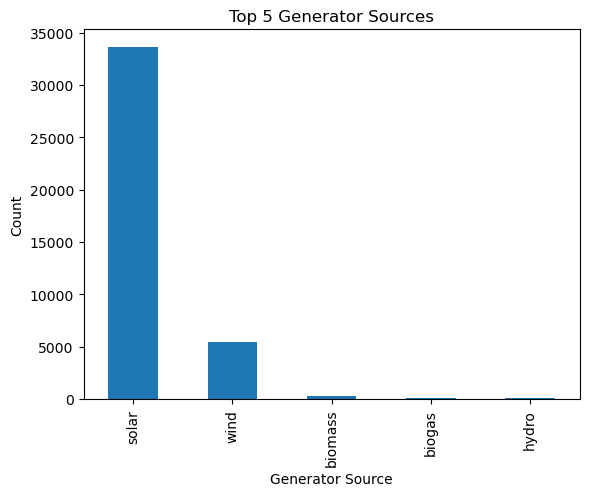

In [235]:
gen['generator:source'].value_counts()

gen['generator:source'].value_counts().head(5).plot(kind='bar')
plt.title('Top 5 Generator Sources')
plt.xlabel('Generator Source')
plt.ylabel('Count')
plt.show()

### Generator capacities if available

In [236]:
# get overview of power output values
pd.set_option('display.max_rows', None)
gen['generator:output:electricity'].value_counts()

generator:output:electricity
yes                   28232
small_installation     5090
2.00 MW                 502
2 MW                    421
1.5 MW                  274
1.50 MW                 209
600 kW                  130
3.45 MW                 117
3.00 MW                 102
2.30 MW                  87
1.80 MW                  83
2.3 MW                   80
3.30 MW                  78
2000 kW                  72
4.2 MW                   68
1.8 MW                   62
850 kW                   59
5.6 MW                   59
3.3 MW                   59
5.7 MW                   51
660 kW                   47
3 MW                     46
1500 kW                  44
3.6 MW                   44
500 kW                   38
800 kW                   37
3.20 MW                  35
2.0 MW                   35
4.20 MW                  34
0.60 MW                  34
2.5 MW                   31
2.05 MW                  30
2.35 MW                  29
0.5 MW                   29
3.0 MW             

In [237]:
gen['output'] = gen['generator:output:electricity']
gen.output.value_counts()
# 'output' contains values such as '2.78 MW'. Split at the whitespace and put value and unit into separate columns
gen[['value', 'unit']] = gen['output'].str.split(' ', expand=True)
# set 'value' to float. Those that cannot be converted will be set to NaN (many observations with 'yes' and 'small_installation')
gen['value'] = pd.to_numeric(gen['value'], errors='coerce')

In [238]:
gen.unit.value_counts()
# set 'unit' to nan if not 'kW' or 'MW'
# simplification ignoring MWp etc., as they are only few cases
gen.loc[~gen['unit'].isin(['kW', 'MW']), 'unit'] = pd.NA

In [239]:
# create a new column 'value_kw' with all values in kW
gen['value_kw'] = gen['value']
gen.loc[gen['unit'] == 'MW', 'value_kw'] = gen['value'] * 1000
gen.value_kw.describe()

count      4045.000000
mean       5042.743283
std       39532.564749
min           0.008000
25%        1500.000000
50%        2000.000000
75%        3000.000000
max      933200.000000
Name: value_kw, dtype: float64

In [240]:
# total capacity of all generators in kW
capacity = gen['value_kw'].sum()
print(f"The total capacity of tagged OSM generators in BB and SN is {round(capacity/1_000_000, 3)} GW")

The total capacity of tagged OSM generators in BB and SN is 20.398 GW
